# Práctica 6 - Clasificador de imágenes con redes neuronales

Guarda una copia de este cuaderno en tu Google Drive para poder editarla y ejecutarla.

El propio cuaderno será tu informe del trabajo. Puedes añadir tantas secciones de código y de texto como consideres necesario para resolver todos los ejercicios propuestos y analizar los resultados obtenidos. Una vez hayas terminado, descarga el notebook en formato ipynb y súbelo a Moodle en la tarea habilitada para la práctica con el nombre NIP_P6.ipynb

Es **obligatorio** que se **guarden los resultados de la evaluación** de cada celda de código (para no tener que volver a ejecutarlas). Por defecto los notebooks estan configurados así (Edit→Notebook Settings → NUNCA actives: Omit code cell output when saving this notebook)

La evaluación de la práctica se realizará mediante una entrevista durante la semana de evaluación continua en la que se deberá mostrar el funcionamiento del cuaderno de Colab y resolver a preguntas relacionadas con su contenido. Evaluación: funcionamiento de colab 50%. Respuesta a las preguntas 50% de la nota.

Imports necesarios para ejecutar el trabajo

In [1]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Flatten, Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.optimizers import RMSprop, Adam, SGD
from keras.callbacks import EarlyStopping
import time
import numpy as np
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [2]:
def plot_history(history):
  loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
  val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
  acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
  val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]

  if len(loss_list) == 0:
      print('Loss is missing in history')
      return

  ## As loss always exists
  epochs = range(1,len(history.history[loss_list[0]]) + 1)

  ## Loss
  fig, axs = plt.subplots(1, 2,  figsize=(12, 6))
  for l in loss_list:
      axs[0].plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
  for l in val_loss_list:
      axs[0].plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))

  axs[0].set(title='Loss', xlabel='Epochs', ylabel='Loss')
  axs[0].grid()
  axs[0].legend()

  ## Accuracy
  for l in acc_list:
      axs[1].plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
  for l in val_acc_list:
      axs[1].plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

  axs[1].set(title='Accuracy', xlabel='Epochs', ylabel='Accuracy')
  axs[1].grid()
  axs[1].legend()
  plt.show()

Carga del dataset MNIST

In [3]:
verbose = True
use_CNN = False

print('Loading MNIST dataset...')
# Problem dimensions
img_rows, img_cols = 28, 28
num_pixels = img_rows * img_cols
num_classes = 10
# The data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
if use_CNN:
  x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
  x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
  input_shape = (img_rows, img_cols, 1)
else:
  x_train = x_train.reshape(60000, num_pixels)
  x_test = x_test.reshape(10000, num_pixels)

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test  = keras.utils.to_categorical(y_test,  num_classes)

np.random.seed(0)
p = np.arange(x_train.shape[0])
np.random.shuffle(p)
x_train = x_train[p]
y_train = y_train[p]


Loading MNIST dataset...
11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
x_train shape: (60000, 784)
60000 train samples
10000 test samples


Ejemplo de definición de la arquitectura de una red y de los parámetros de la optimización.

In [4]:
# Función para parar cuando ya no mejora el error en los datos de validacion
earlystop=EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')
model = Sequential()
if use_CNN:
  # Red convolucional
  model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation='softmax'))
else:
  # Perceptron de un solo nivel
  model.add(Dense(10, activation='sigmoid', input_shape=(num_pixels,)))


model.compile(loss='categorical_crossentropy', optimizer=Adam(),  metrics=['accuracy'])
model.summary()



/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │           7,850 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,850 (30.66 KB)

 Trainable params: 7,850 (30.66 KB)

 Non-trainable params: 0 (0.00 B)

Código para entrenar la red neuronal utilizando la función FIT

Observa como incluye un argumento para hacer separación de datos de validación



Epoch 1/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7125 - loss: 1.0869 - val_accuracy: 0.8883 - val_loss: 0.4140
Epoch 2/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8976 - loss: 0.3872 - val_accuracy: 0.9037 - val_loss: 0.3424
Epoch 3/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9088 - loss: 0.3304 - val_accuracy: 0.9125 - val_loss: 0.3155
Epoch 4/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9161 - loss: 0.3028 - val_accuracy: 0.9160 - val_loss: 0.3031
Epoch 5/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9196 - loss: 0.2903 - val_accuracy: 0.9172 - val_loss: 0.2950
Epoch 6/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9218 - loss: 0.2837 - val_accuracy: 0.9155 - val_loss: 0.2907
Epoch 7/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9236 - loss: 0.2782 - val_accuracy: 0.9180 - val_loss: 0.2845
Epoch 8/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9248 - loss: 0.2709 - val_accuracy: 0.

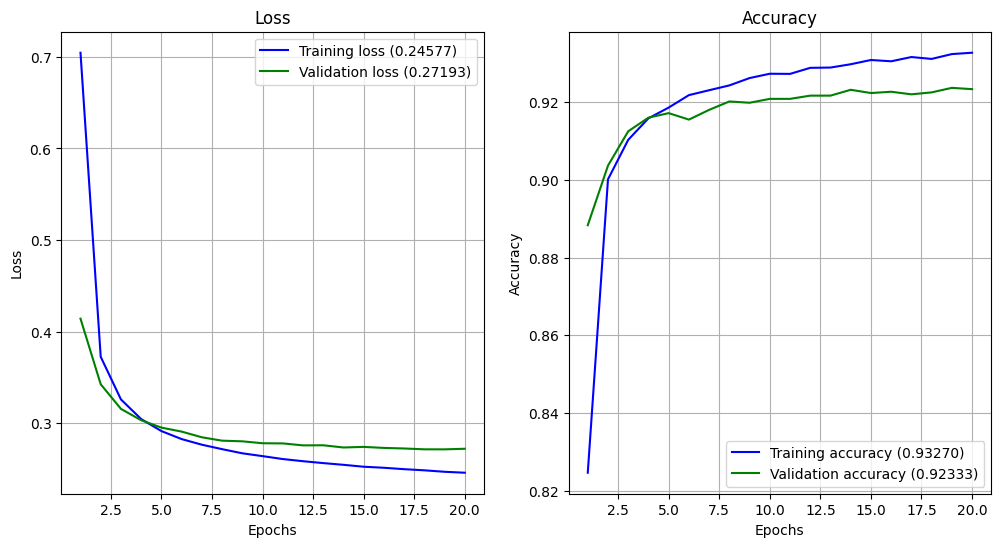

In [5]:
t0 = time.perf_counter()
history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=20,
                    validation_split=0.1,
                    callbacks=[earlystop],
                    verbose=verbose)

train_time = time.perf_counter() - t0
print('%s %.3f%s' %  ('Training time: ', train_time, 's') )
plot_history(history)

## Preguntas a responder de la celda anterior


### 1 - ¿Qué representan los parámetros batch_size y epochs? (Respuesta dos líneas max).

**Batch_size**: es el número de muestras de datos (número de ejemplos de entrenamiento) que se procesan antes de actualizar los parámetros del modelo en una red neuronal. **Epochs**: es el número de veces que el algoritmo trabaja sobre el conjunto completo de datos.

### 2 - Explica las dos gráficas que se muestran al finalizar el entrenamiento.

Las gráficas muestran la evolución de la pérdida (loss) y la precisión (accuracy) del modelo durante el entrenamiento y la validación a lo largo de los epochs.

*   **Gráfica de Loss:**
    El eje X representa los epochs (pasada completa sobre el conjunto de entrenamiento), y el eje Y representa el loss (medida que sirve para ver cuánto se equivoca el modelo de media durante el entrenamiento y la validación).

    La línea azul muestra el loss en el conjunto de entrenamiento y la verde muestra la pérdida en el conjunto de validación.

    La disminución de la línea azul muestra que el modelo está aprendiendo y ajustando mejor sus predicciones con cada epoch sobre el conjunto de entrenamiento.

    La línea verde también disminuye, aunque tiene algunos cambios que aumentan y disminuyen un poco de un epoch a otro. Esto es normal porque el modelo está evaluando en datos que no ha visto durante en el entrenamiento (que son los datos de validación).
*   **Gráfica de precisión / accuracy:**
    El eje X representa los epochs y el eje Y representa la precisión, es decir, el porcentaje de los que predijo correctamente.
    La línea azul muestra la precisión en el entrenamiento, y la línea verde la precisión en el conjunto de validación.

    La precisión durante el entrenamiento (línea azul), mejora y se va estabilizando en valores muy altos. Esto muestra que el modelo es capaz de reconocer y clasificar correctamente la mayoría de las muestras de entrenamiento.

    La precisión en la validación (línea verde) también es alta y muestra que también generaliza bien los nuevos datos de validación que no ha visto durante el entrenamiento.


Evaluación de la red

In [6]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    #plt.tight_layout()


def plot_mnist_confusion_matrix(y_test, y_pred, normalize=False):
    class_names=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    y_tst = [np.argmax(y) for y in y_test]
    y_prd = [np.argmax(y) for y in y_pred]

    cnf_matrix = confusion_matrix(y_tst, y_prd)

    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                          normalize=normalize)

Accuracy train:  93.29%
Accuracy test:   92.72%
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Confusion matrix, without normalization


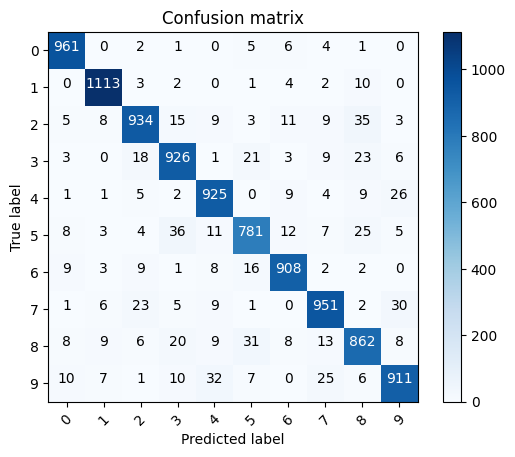

In [7]:
# Evaluar la red
train_score = model.evaluate(x_train, y_train, verbose=0)
test_score = model.evaluate(x_test, y_test, verbose=0)
print('%s %2.2f%s' % ('Accuracy train: ', 100*train_score[1], '%' ))
print('%s %2.2f%s' % ('Accuracy test:  ', 100*test_score[1], '%'))

y_pred = model.predict(x_test)
plot_mnist_confusion_matrix(y_test, y_pred, normalize=False)
# Standard confusion matrix plot
#cm=confusion_matrix(np.argmax(y_test, axis=1),np.argmax(y_pred, axis=1))
#plt.imshow(cm, cmap='Blues')

## Preguntas a responder de la celda anterior

### 3 - Explica la gráfica que se muestra

La gráfica es una matriz de confusión que sirve para evaluar el rendimiento del modelo de clasificación de dígitos del 0 al 9. Esta gráfica ha sido generada a partir de los datos test, por lo que el modelo ya ha sido entrenado previamente y ahora nos encontramos en la fase de evaluación.

En el eje X, se muestran las etiquetas que ha predicho el modelo.

En el eje Y, se muestran las etiquetas verdaderas, es decir, la clase real de cada imagen.

Las celdas en la diagonal principal indican el número de predicciones correctas para cada clase (979 para el 0, 1132 para el 1...).

Las celdas fuera de la diagonal muestran los errores de clasificación.

Se observa que el modelo tiene un alto rendimiento en la clasificación correcta de los números, ya que la mayoría de las predicciones están en la diagonal principal, mientras que fuera de la diagonal hay valores bajos o 0.

Los valores distintos de 0 fuera de la diagonal, muestran que ciertos números pueden confundirse con otros, lo cual puede indicar dónde el modelo podría mejorar.

## TRABAJO PRÁCTICO


**Trabajo práctico**: incluye a continuación las secciones de código para probar las diferentes redes.
No incluyas una sección para cada red que pruebes. El notebook que entregues deberá incluir:


4.1.   La mejor red obtenida para el caso de una capa

4.2.   La mejor red obtenida para el caso de dos capas

4.3.   La mejor red obtenida para el caso de tres capas

4.4.   Ejemplo de red en la que se produzca sobreajuste al entrenar

4.5.   Modificación de la red anterior utilizando técnicas para evitar el sobreajuste

4.6.   Ejecuta la red convolucional y compara el resultado con los obtenidos utilizando perceptrón.

4.7.   Incluye en una sección de texto una tabla en la que aparezca resumido el conjunto de pruebas realizado y los resultados obtenidos en cada caso (nº capas, nº neuronas, accuracy, técnicas de sobreajuste, etc.). Incluye en esta sección también las conclusiones obtenidas del trabajo.

4.8.   Recuerda mostrar y comentar algún ejemplo de imagen mal clasificada por la red que mejor se comporte.

4.9.   Opcional: Evalua el rendimiento de un MLP y una CNN en un dataset diferente (CIFAR10, CIFAR100, etc. Puedes ver más opciones de datasets para clasifición en imágenes en www.tensorflow.org/datasets/catalog/overview?hl=es)



#**PREGUNTA 4.1**

Este código evalúa un modelo usando configuraciones diferentes de parámetros para determinar cuál produce una mayor precisión.

In [8]:
import pandas as pd
from IPython.display import display

results = []
mejor_accuracy = 0
iterador = 0

for loss in ['categorical_crossentropy', 'mean_squared_error']:
  for fa1 in ['softmax', 'sigmoid']:
    print(f'Vamos a usar-> primera capa: {fa1}, loss: {loss}')
    print(f'Número de iteración: {iterador}')
    iterador=iterador+1

    # Función para parar cuando ya no mejora el error en los datos de validacion
    earlystop=EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')

    model = Sequential()

    model.add(Dense(10, activation=fa1, input_shape=(num_pixels,)))

    model.compile(loss=loss, optimizer=Adam(),  metrics=['accuracy'])

    t0 = time.perf_counter()
    history = model.fit(x_train, y_train,
                        batch_size=128,
                        epochs=20,
                        validation_split=0.1,
                        callbacks=[earlystop],
                        verbose=verbose)

    train_time = time.perf_counter() - t0

    train_score = model.evaluate(x_train, y_train, verbose=0)
    test_score = model.evaluate(x_test, y_test, verbose=0)

    accuracy_test = 100 * test_score[1]
    if accuracy_test > mejor_accuracy:
      mejor_accuracy = accuracy_test
      funcion_activacion_elegida1 = fa1
      loss_elegido = loss

    # Almacenar resultados
    results.append({
      'Capa 1:': fa1,
      'Loss': loss,
      'Test Accuracy': accuracy_test
    })

results_df = pd.DataFrame(results)
pd.options.display.float_format = '{:,.2f}%'.format
display(results_df)
print(f'')

print(f'Mejor accuracy: {mejor_accuracy:.2f}%')
print(f'Función de activación utilizada: {funcion_activacion_elegida1}')
print(f'Loss utilizado: {loss_elegido}')

Vamos a usar-> primera capa: softmax, loss: categorical_crossentropy
Número de iteración: 0


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7255 - loss: 1.0706 - val_accuracy: 0.8897 - val_loss: 0.4128
Epoch 2/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8959 - loss: 0.3936 - val_accuracy: 0.9050 - val_loss: 0.3435
Epoch 3/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9091 - loss: 0.3316 - val_accuracy: 0.9127 - val_loss: 0.3168
Epoch 4/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9135 - loss: 0.3118 - val_accuracy: 0.9155 - val_loss: 0.3051
Epoch 5/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9191 - loss: 0.2909 - val_accuracy: 0.9173 - val_loss: 0.2944
Epoch 6/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9226 - loss: 0.2830 - val_accuracy: 0.9167 - val_loss: 0.2899
Epoch 7/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9225 - loss: 0.2757 - val_accuracy: 0.9187 - val_loss: 0.2846
Epoch 8/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9251 - loss: 0.2728 - val_accuracy: 0.

,Capa 1:,Loss,Test Accuracy
0,softmax,categorical_crossentropy,92.66%
1,sigmoid,categorical_crossentropy,92.68%
2,softmax,mean_squared_error,93.18%
3,sigmoid,mean_squared_error,92.29%



Mejor accuracy: 93.18%
Función de activación utilizada: softmax
Loss utilizado: mean_squared_error


Estos son los datos obtenidos:

| Capa 1  | Loss                     | Test Accuracy |
|---------|--------------------------|---------------|
| softmax | categorical_crossentropy | 92.65%        |
| sigmoid | categorical_crossentropy | 92.71%        |
| softmax | mean_squared_error       | 93.17%        |
| sigmoid | mean_squared_error       | 92.35%        |

Mejor accuracy: 93.17%

Función de activación utilizada: softmax

Loss utilizado: mean_squared_error


A continuación vamos a probar a evaluar con los parámetros que hemos obtenido:

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_28 (Dense)                     │ (None, 10)                  │           7,850 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,850 (30.66 KB)

 Trainable params: 7,850 (30.66 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 51s 5ms/step - accuracy: 0.6934 - loss: 0.0462 - val_accuracy: 0.8952 - val_loss: 0.0174
Epoch 2/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9046 - loss: 0.0162 - val_accuracy: 0.9107 - val_loss: 0.0147
Epoch 3/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9142 - loss: 0.0140 - val_accuracy: 0.9162 - val_loss: 0.0135
Epoch 4/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9198 - loss: 0.0129 - val_accuracy: 0.9197 - val_loss: 0.0128
Epoch 5/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9227 - loss: 0.0124 - val_accuracy: 0.9208 - val_loss: 0.0125
Epoch 6/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9267 - loss: 0.0118 - val_accuracy: 0.9237 - val_loss: 0.0122
Epoch 7/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9282 - loss: 0.0116 - val_accuracy: 0.9223 - val_loss: 0.0121
Epoch 8/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9303 - loss: 0.0111 - val_accuracy: 0

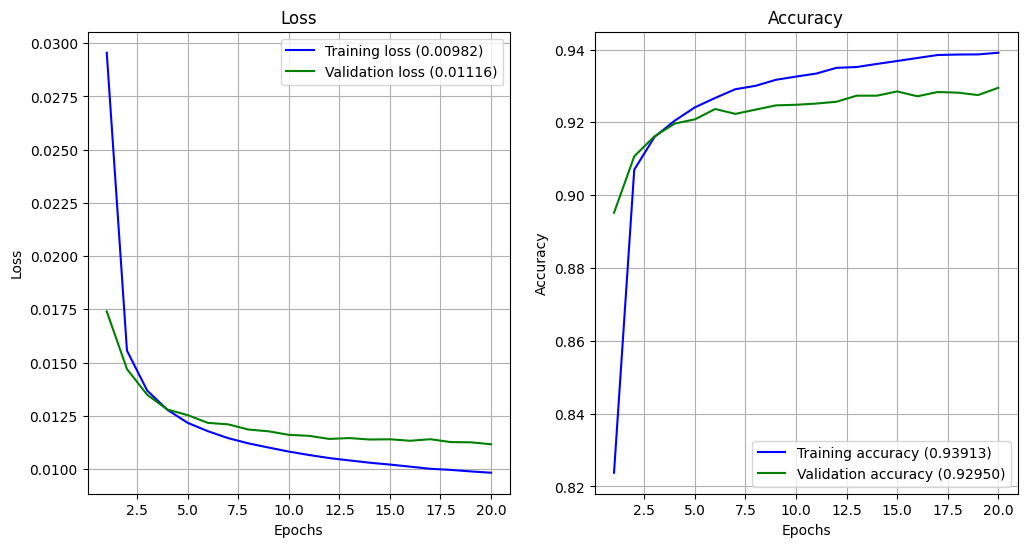

Confusion matrix, without normalization


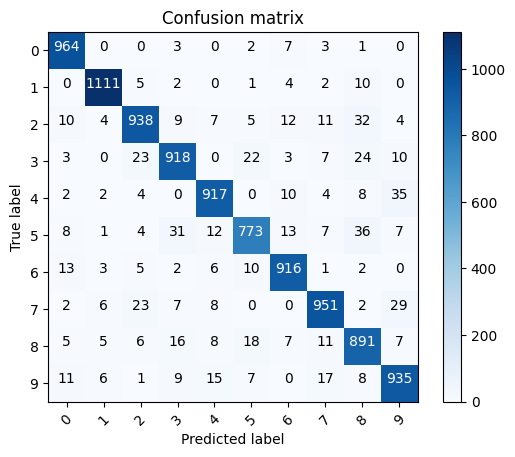

In [ ]:
# Función para parar cuando ya no mejora el error en los datos de validacion
earlystop=EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')

model = Sequential()
# Perceptron de un solo nivel
model.add(Dense(10, activation="softmax", input_shape=(num_pixels,)))

model.compile(loss="mean_squared_error", optimizer=Adam(),  metrics=['accuracy'])
model.summary()

t0 = time.perf_counter()
history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=20,
                    validation_split=0.1,
                    callbacks=[earlystop],
                    verbose=verbose)
train_time = time.perf_counter() - t0
print('%s %.3f%s' %  ('Training time: ', train_time, 's') )
train_score = model.evaluate(x_train, y_train, verbose=0)
test_score = model.evaluate(x_test, y_test, verbose=0)
print(f'Accuracy train: {100 * train_score[1]:.2f}%')
print(f'Accuracy test: {100 * test_score[1]:.2f}%')
y_pred = model.predict(x_test)

plot_history(history)

plot_mnist_confusion_matrix(y_test, y_pred, normalize=False)

#**PREGUNTA 4.2**

Este código evalúa un modelo usando configuraciones diferentes de parámetros para determinar cuál produce una mayor precisión.



In [ ]:
import pandas as pd
from IPython.display import display

mejor_accuracy = 0
results = []
iterador = 0

for numNeuronas in [10,32,64,128]:
  for loss in ['categorical_crossentropy', 'mean_squared_error']:
    for fa1 in ['softmax', 'sigmoid', 'relu']:
      for fa2 in ['softmax', 'sigmoid']:
        print(f'Vamos a usar-> primera capa: {fa1}, segunda capa: {fa2}, neuronas capa1: {numNeuronas}, loss: {loss}')
        print(f'Número de iteración: {iterador}')
        iterador=iterador+1
        # Función para parar cuando ya no mejora el error en los datos de validacion
        earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')

        model = Sequential()
        model.add(Dense(numNeuronas, activation=fa1, input_shape=(num_pixels,)))
        model.add(Dense(10, activation=fa2))

        model.compile(loss=loss, optimizer=Adam(),  metrics=['accuracy'])

        t0 = time.perf_counter()
        history = model.fit(x_train, y_train,
                            batch_size=128,
                            epochs=20,
                            validation_split=0.1,
                            callbacks=[earlystop],
                            verbose=verbose)
        train_time = time.perf_counter() - t0

        train_score = model.evaluate(x_train, y_train, verbose=0)
        test_score = model.evaluate(x_test, y_test, verbose=0)

        accuracy_test = 100 * test_score[1]
        if accuracy_test > mejor_accuracy:
          mejor_accuracy = accuracy_test
          funcion_activacion_elegida1 = fa1
          funcion_activacion_elegida2 = fa2
          num_neuronas_elegido = numNeuronas
          loss_elegido = loss

        # Almacenar resultados
        results.append({
          'Capa 1:': fa1,
          'Neuronas capa 1:': numNeuronas,
          'Capa 2:': fa2,
          'Loss': loss,
          'Test Accuracy': accuracy_test
        })

results_df = pd.DataFrame(results)
pd.options.display.float_format = '{:,.2f}%'.format
display(results_df)
print(f'')

print(f'Mejor accuracy: {mejor_accuracy:.2f}%')
print(f'Función de activación utilizada para la primera: {funcion_activacion_elegida1}')
print(f'Función de activación utilizada para la segunda: {funcion_activacion_elegida2}')
print(f'Número de neuronas de la primera capa: {num_neuronas_elegido}')
print(f'Loss utilizado: {loss_elegido}')


Estos son los datos obtenidos:

| Capa 1  | Neuronas capa 1 | Capa 2  | Loss                     | Test Accuracy |
|---------|-----------------|---------|--------------------------|---------------|
| softmax | 10              | softmax | categorical_crossentropy | 86.48%        |
| sigmoid | 10              | softmax | categorical_crossentropy | 88.41%        |
| sigmoid | 10              | softmax | categorical_crossentropy | 92.46%        |
| relu    | 10              | softmax | categorical_crossentropy | 93.97%        |
| relu    | 10              | softmax | categorical_crossentropy | 93.65%        |
| softmax | 10              | sigmoid | mean_squared_error       | 90.49%        |
| softmax | 10              | sigmoid | mean_squared_error       | 42.44%        |
| ... | ...              | ... | ...       | ...        |
| softmax | 128             | softmax | categorical_crossentropy | 93.73%        |
| softmax | 128             | softmax | categorical_crossentropy | 92.24%        |
| sigmoid | 128             | softmax | categorical_crossentropy | 97.49%        |
| sigmoid | 128             | softmax | categorical_crossentropy | 97.65%        |
| relu    | 128             | softmax | categorical_crossentropy | 97.73%        |
| relu    | 128             | softmax | categorical_crossentropy | 97.62%        |
| softmax | 128             | sigmoid | mean_squared_error       | 92.27%        |
| softmax | 128             | sigmoid | mean_squared_error       | 21.29%        |
| sigmoid | 128             | sigmoid | mean_squared_error       | 97.62%        |
| sigmoid | 128             | sigmoid | mean_squared_error       | 97.19%        |
| relu    | 128             | sigmoid | mean_squared_error       | 97.92%        |
| relu    | 128             | sigmoid | mean_squared_error       | 97.96%        |

Mejor accuracy: 97.96%

Función de activación utilizada para la primera: relu

Función de activación utilizada para la segunda: sigmoid

Número de neuronas de la primera capa: 128

Loss utilizado: mean_squared_error



A continuación vamos a probar a evaluar con los parámetros que hemos obtenido:

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                      │ (None, 128)                 │         100,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 101,770 (397.54 KB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7021 - loss: 0.0526 - val_accuracy: 0.9242 - val_loss: 0.0142
Epoch 2/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9306 - loss: 0.0129 - val_accuracy: 0.9402 - val_loss: 0.0107
Epoch 3/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9483 - loss: 0.0095 - val_accuracy: 0.9520 - val_loss: 0.0084
Epoch 4/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9569 - loss: 0.0078 - val_accuracy: 0.9580 - val_loss: 0.0072
Epoch 5/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9656 - loss: 0.0064 - val_accuracy: 0.9670 - val_loss: 0.0063
Epoch 6/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9716 - loss: 0.0055 - val_accuracy: 0.9680 - val_loss: 0.0059
Epoch 7/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9750 - loss: 0.0049 - val_accuracy: 0.9708 - val_loss: 0.0054
Epoch 8/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9790 - loss: 0.0042 - val_accuracy: 0.

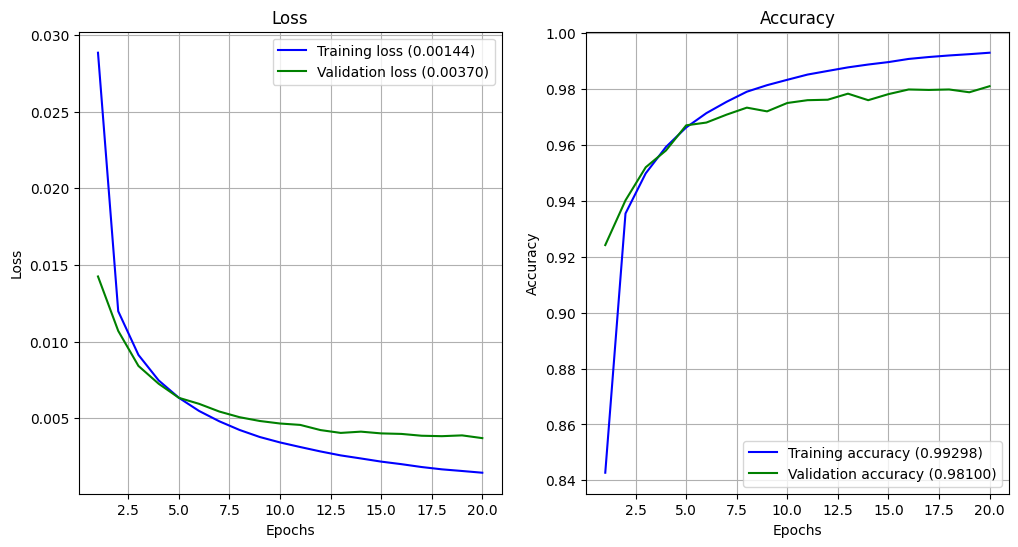

Confusion matrix, without normalization


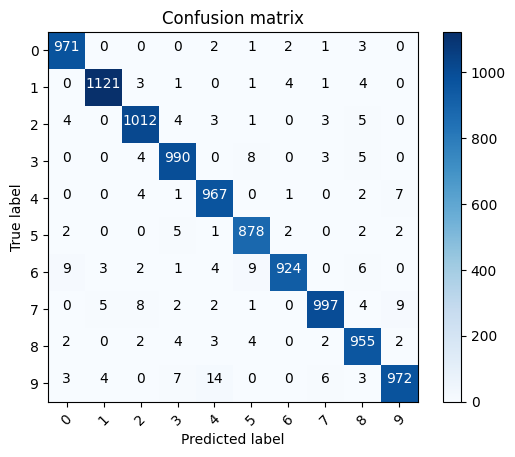

In [ ]:
earlystop=EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')

model = Sequential()

# Perceptron de un solo nivel
model.add(Dense(128, "relu", input_shape=(num_pixels,)))
model.add(Dense(10, "sigmoid"))
model.compile(loss="mean_squared_error", optimizer=Adam(),  metrics=['accuracy'])

model.summary()

t0 = time.perf_counter()
history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=20,
                    validation_split=0.1,
                    callbacks=[earlystop],
                    verbose=verbose)
train_time = time.perf_counter() - t0
print('%s %.3f%s' %  ('Training time: ', train_time, 's') )
train_score = model.evaluate(x_train, y_train, verbose=0)
test_score = model.evaluate(x_test, y_test, verbose=0)
print(f'Accuracy train: {100 * train_score[1]:.2f}%')
print(f'Accuracy test: {100 * test_score[1]:.2f}%')
y_pred = model.predict(x_test)

plot_history(history)

plot_mnist_confusion_matrix(y_test, y_pred, normalize=False)

#**PREGUNTA 4.3**

Este código evalúa un modelo usando configuraciones diferentes de parámetros para determinar cuál produce una mayor precisión.

In [ ]:
import pandas as pd
from IPython.display import display

mejor_accuracy = 0
iterador = 0
results = []


for numNeuronas1 in [64,128]:
  for numNeuronas2 in [64,128]:
    for loss in ['categorical_crossentropy', 'mean_squared_error']:
      for fa1 in ['softmax', 'sigmoid', 'relu']:
        for fa2 in ['softmax', 'sigmoid', 'relu']:
          for fa3 in ['softmax', 'sigmoid']:
            print(f'Vamos a usar-> primera capa: {fa1}, segunda capa: {fa2}, tercera capa: {fa3}, neuronas capa1: {numNeuronas1}, neuronas capa2: {numNeuronas2}, loss: {loss}')
            print(f'Número de iteración: {iterador}')
            iterador=iterador+1

            earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')

            model = Sequential()
            model.add(Dense(numNeuronas1, activation=fa1, input_shape=(num_pixels,)))
            model.add(Dense(numNeuronas2, activation=fa2))
            model.add(Dense(10, activation=fa3))

            model.compile(loss=loss, optimizer=Adam(),  metrics=['accuracy'])

            t0 = time.perf_counter()
            history = model.fit(x_train, y_train,
                                batch_size=128,
                                epochs=20,
                                validation_split=0.1,
                                callbacks=[earlystop],
                                verbose=verbose)
            train_time = time.perf_counter() - t0

            train_score = model.evaluate(x_train, y_train, verbose=0)
            test_score = model.evaluate(x_test, y_test, verbose=0)

            accuracy_test = 100 * test_score[1]
            if accuracy_test > mejor_accuracy:
              mejor_accuracy = accuracy_test
              funcion_activacion_elegida1 = fa1
              funcion_activacion_elegida2 = fa2
              funcion_activacion_elegida3 = fa3
              num_neuronas_elegido1 = numNeuronas1
              num_neuronas_elegido2 = numNeuronas2
              loss_elegido = loss

            # Almacenar resultados
            results.append({
              'Capa 1:': fa1,
              'Neuronas capa 1:': numNeuronas1,
              'Capa 2:': fa2,
              'Neuronas capa 2:': numNeuronas2,
              'Capa 3:': fa3,
              'Loss': loss,
              'Test Accuracy': accuracy_test
            })

results_df = pd.DataFrame(results)
pd.options.display.float_format = '{:,.2f}%'.format
display(results_df)
print(f'')


print(f'Mejor accuracy: {mejor_accuracy:.2f}%')
print(f'Función de activación utilizada para la primera: {funcion_activacion_elegida1}')
print(f'Función de activación utilizada para la segunda: {funcion_activacion_elegida2}')
print(f'Función de activación utilizada para la segunda: {funcion_activacion_elegida3}')
print(f'Número de neuronas de la primera capa: {num_neuronas_elegido1}')
print(f'Número de neuronas de la segunda capa: {num_neuronas_elegido1}')
print(f'Loss utilizado: {loss_elegido}')


Estos son los datos obtenidos:

| Capa 1  | Neuronas capa 1 | Capa 2  | Neuronas capa 2 | Capa 3  | Neuronas capa 3 | Loss                     | Test Accuracy |
|---------|-----------------|---------|-----------------|---------|-----------------|--------------------------|---------------|
| softmax | 64              | softmax | 64              | softmax | 64              | categorical_crossentropy | 93.21%        |
| softmax | 64              | softmax | 64              | sigmoid | 64              | categorical_crossentropy | 92.68%        |
| softmax | 64              | sigmoid | 64              | softmax | 64              | categorical_crossentropy | 94.85%        |
| softmax | 64              | sigmoid | 64              | sigmoid | 64              | categorical_crossentropy | 94.07%        |
| softmax | 64              | relu    | 64              | softmax | 64              | categorical_crossentropy | 95.52%        |
| ...     | ...             | ...     | ...             | ...     | ...             | ...                      | ...           |
| relu    | 128             | softmax | 128             | sigmoid | 128             | mean_squared_error       | 31.12%        |
| relu    | 128             | sigmoid | 128             | softmax | 128             | mean_squared_error       | 97.71%        |
| relu    | 128             | sigmoid | 128             | sigmoid | 128             | mean_squared_error       | 97.71%        |
| relu    | 128             | relu    | 128             | softmax | 128             | mean_squared_error       | 97.65%        |
| relu    | 128             | relu    | 128             | sigmoid | 128             | mean_squared_error       | 97.99%        |

Mejor accuracy: 97.99%

Función de activación utilizada para la primera: relu

Función de activación utilizada para la segunda: relu

Función de activación utilizada para la segunda: sigmoid

Número de neuronas de la primera capa: 128

Número de neuronas de la segunda capa: 128

Loss utilizado: mean_squared_error


A continuación vamos a probar a evaluar con los parámetros que hemos obtenido:

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 128)                 │         100,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 118,282 (462.04 KB)

 Trainable params: 118,282 (462.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6637 - loss: 0.0523 - val_accuracy: 0.9393 - val_loss: 0.0105
Epoch 2/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9465 - loss: 0.0092 - val_accuracy: 0.9588 - val_loss: 0.0072
Epoch 3/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9639 - loss: 0.0063 - val_accuracy: 0.9658 - val_loss: 0.0059
Epoch 4/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9720 - loss: 0.0050 - val_accuracy: 0.9683 - val_loss: 0.0053
Epoch 5/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9788 - loss: 0.0039 - val_accuracy: 0.9728 - val_loss: 0.0047
Epoch 6/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9819 - loss: 0.0033 - val_accuracy: 0.9757 - val_loss: 0.0042
Epoch 7/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9855 - loss: 0.0027 - val_accuracy: 0.9777 - val_loss: 0.0039
Epoch 8/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9871 - loss: 0.0024 - val_accuracy: 0.

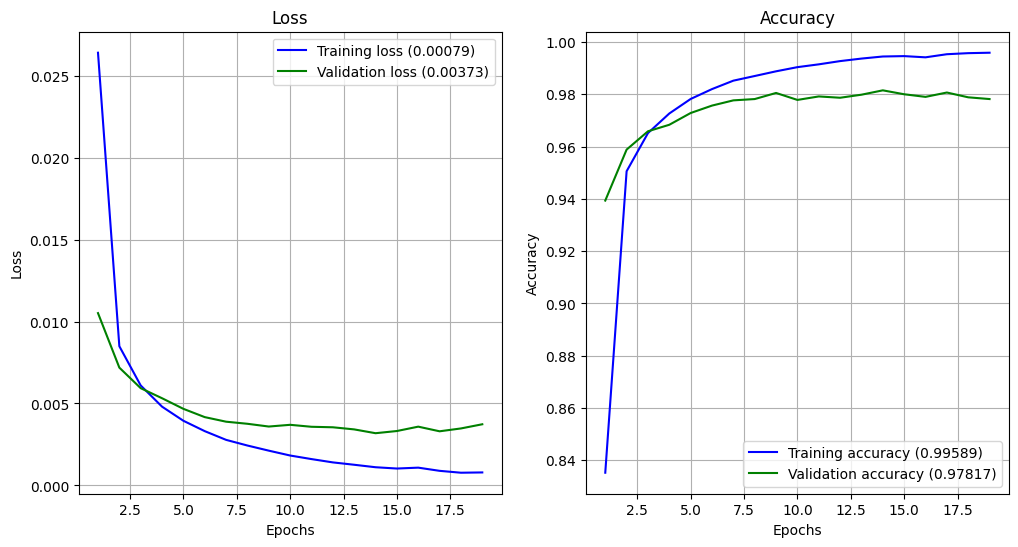

Confusion matrix, without normalization


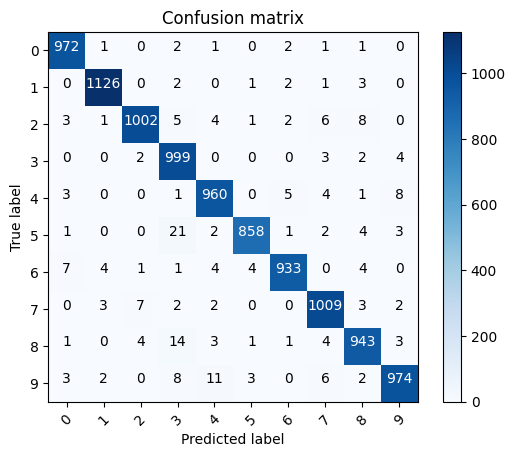

In [9]:
earlystop=EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')
model = Sequential()

# Perceptron de un solo nivel
model.add(Dense(128, activation='relu', input_shape=(num_pixels,)))
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='sigmoid'))


model.compile(loss='mean_squared_error', optimizer=Adam(),  metrics=['accuracy'])
model.summary()

t0 = time.perf_counter()
history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=20,
                    validation_split=0.1,
                    callbacks=[earlystop],
                    verbose=verbose)
train_time = time.perf_counter() - t0
print('%s %.3f%s' %  ('Training time: ', train_time, 's') )
train_score = model.evaluate(x_train, y_train, verbose=0)
test_score = model.evaluate(x_test, y_test, verbose=0)
print(f'Accuracy train: {100 * train_score[1]:.2f}%')
print(f'Accuracy test: {100 * test_score[1]:.2f}%')
y_pred = model.predict(x_test)

plot_history(history)

plot_mnist_confusion_matrix(y_test, y_pred, normalize=False)


# **PREGUNTA 4.4**

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                      │ (None, 512)                 │         401,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 535,818 (2.04 MB)

 Trainable params: 535,818 (2.04 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.8712 - loss: 0.4420 - val_accuracy: 0.9622 - val_loss: 0.1244
Epoch 2/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.9715 - loss: 0.0925 - val_accuracy: 0.9747 - val_loss: 0.0830
Epoch 3/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.9822 - loss: 0.0581 - val_accuracy: 0.9797 - val_loss: 0.0713
Epoch 4/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9882 - loss: 0.0373 - val_accuracy: 0.9763 - val_loss: 0.0729
Epoch 5/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.9917 - loss: 0.0263 - val_accuracy: 0.9822 - val_loss: 0.0636
Epoch 6/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.9926 - loss: 0.0215 - val_accuracy: 0.9785 - val_loss: 0.0763
Epoch 7/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.9949 - loss: 0.0156 - val_accuracy: 0.9815 - val_loss: 0.0718
Epoch 8/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.9944 - loss: 0.0168 - val

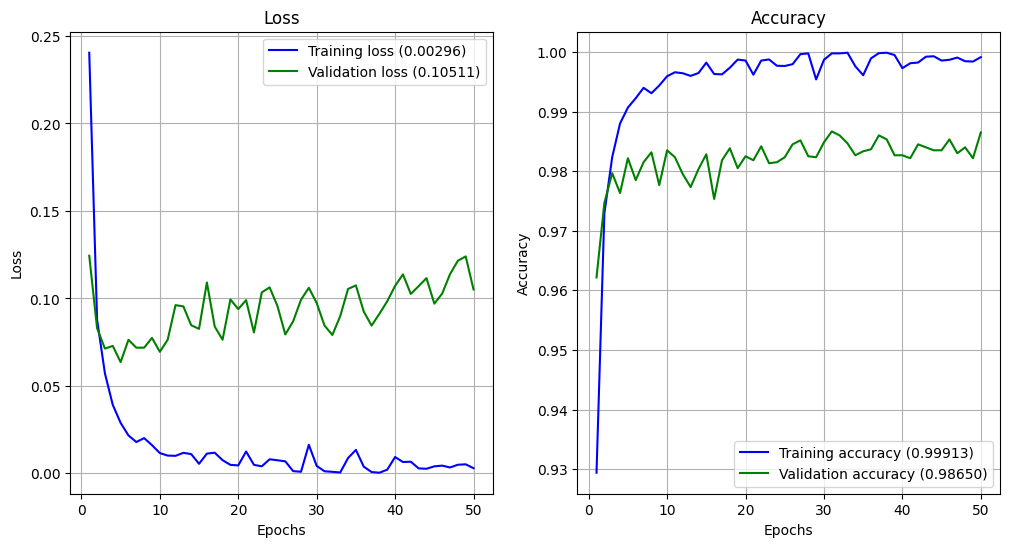

In [10]:
model = Sequential()

# Incrementando el número de neuronas
model.add(Dense(512, activation='relu', input_shape=(num_pixels,)))
model.add(Dense(256, activation='relu'))
model.add(Dense(10, activation='softmax'))

# Compilando el modelo con una tasa de aprendizaje potencialmente alta para rápido aprendizaje
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
model.summary()

# Entrenamiento del modelo sin Early Stopping
history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=50,  # Incrementando el número de epochs para conducir a un sobreajuste
                    validation_split=0.1,
                    verbose=1)

train_score = model.evaluate(x_train, y_train, verbose=0)
test_score = model.evaluate(x_test, y_test, verbose=0)
print(f'Accuracy train: {100 * train_score[1]:.2f}%')
print(f'Accuracy test: {100 * test_score[1]:.2f}%')
plot_history(history)


En las gráficas se observa un claro sobreajuste.

En primer lugar las líneas de pérdida y precisión para los datos de entrenamiento y de validación, actúan muy diferente.

La línea azul de la pérdida sigue bajando, lo cual normalmente estaría correcto porque significaría que el modelo está aprendiendo bien los datos de entrenamiento. Sin embargo, la línea verde de la pérdida (que muestra cómo clasifica los datos nuevos de validación que no ha visto durante el entreno), empieza a subir y a bajar. Esto significa que el modelo está memorizando los datos de entrenamiento y no aprendiendo más.

Además la precisión para los datos de entrenamiento es casi perfecta, pero para los datos nuevos no mejora mucho (es decir, que el modelo no es bueno para predecir nuevas cosas).

# **PREGUNTA 4.5**

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                     │ (None, 512)                 │         401,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 535,818 (2.04 MB)

 Trainable params: 535,818 (2.04 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.8716 - loss: 0.4489 - val_accuracy: 0.9590 - val_loss: 0.1339
Epoch 2/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9726 - loss: 0.0897 - val_accuracy: 0.9743 - val_loss: 0.0853
Epoch 3/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.9836 - loss: 0.0553 - val_accuracy: 0.9757 - val_loss: 0.0788
Epoch 4/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.9878 - loss: 0.0385 - val_accuracy: 0.9795 - val_loss: 0.0740
Epoch 5/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.9923 - loss: 0.0254 - val_accuracy: 0.9817 - val_loss: 0.0741
Epoch 5: early stopping
Accuracy train: 99.41%
Accuracy test: 98.08%


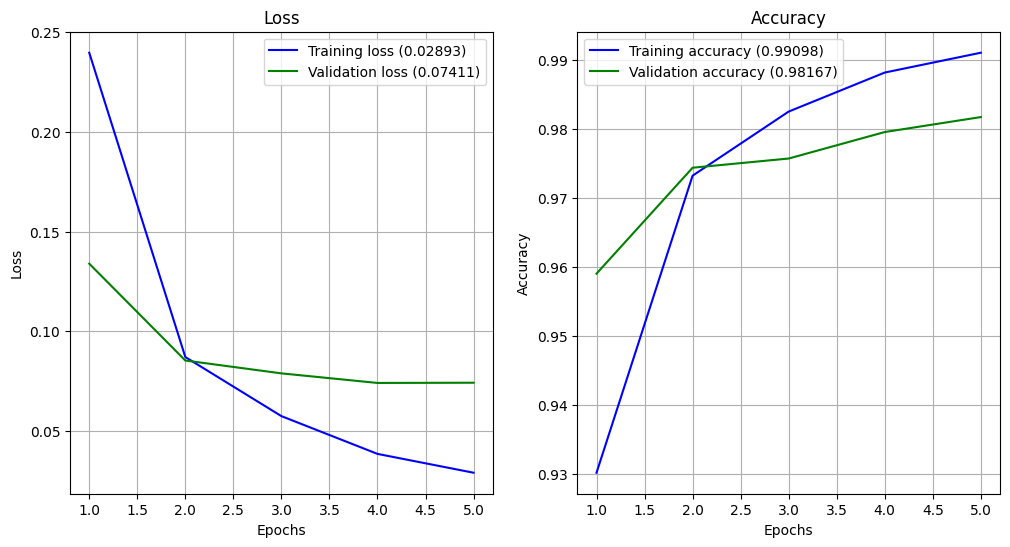

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')

model = Sequential()

model.add(Dense(512, activation='relu', input_shape=(num_pixels,)))
model.add(Dense(256, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
model.summary()

history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=50,
                    validation_split=0.1,
                    callbacks=[earlystop],
                    verbose=1)

train_score = model.evaluate(x_train, y_train, verbose=0)
test_score = model.evaluate(x_test, y_test, verbose=0)
print(f'Accuracy train: {100 * train_score[1]:.2f}%')
print(f'Accuracy test: {100 * test_score[1]:.2f}%')
plot_history(history)

La pérdida de validación ha dejado de aumentar y se ha mantenido baja.
La precisión en la validación también ha mejorado bastante y se mantiene más cercana a la precisión de entrenamiento, por lo que el modelo está analizando mejor los nuevos datos.

# **PREGUNTA 4.6**

Al comparar las gráficas de la red convolucional y el perceptrón multicapa con funciones de activación relu, relu y sigmoid, se observan estas diferencias:

Para la red convolucional, la precisión en los datos de validación es de 99.183%, mientras que en la precisión de entrenamiento es del 99.928%. Esto muestra una diferencia muy pequeña entre el entrenamiento y la validación, indicando una gran generalización del modelo a nuevos datos.

Por otro lado, el preceptrón multicapa obtiene una precisión de entrenamiento de 99.661%, y una precisión de validación de 98.050%.

Pese a que ambos porcentajes son altos, la diferencia entre la precisión de entrenamiento y validación es mayor en el perceptrón multicapa, lo que puede significar un sobreajuste por la incapacidad de generalizar más eficientemente como la otra red.

En resumen, la red convolucional obtiene mejores resultados y tiene un mejor rendimiento.



#**PREGUNTA 4.7 y 4.8**

### 4 - Respuesta a la pregunta 4.7

Después de realizar un extenso conjunto de experimentos con diferentes configuraciones de redes neuronales, los resultados se han resumido en las siguientes tablas:

Parámetros probados red con 1 capa:

| Capa 1  | Loss                     | Test Accuracy |
|---------|--------------------------|---------------|
| softmax | categorical_crossentropy | 92.65%        |
| sigmoid | categorical_crossentropy | 92.71%        |
| softmax | mean_squared_error       | 93.17%        |
| sigmoid | mean_squared_error       | 92.35%        |


Parámetros probados para red con 2 capas:


| Capa 1  | Neuronas capa 1 | Capa 2  | Loss                     | Test Accuracy |
|---------|-----------------|---------|--------------------------|---------------|
| softmax | 10              | softmax | categorical_crossentropy | 86.48%        |
| sigmoid | 10              | softmax | categorical_crossentropy | 88.41%        |
| sigmoid | 10              | softmax | categorical_crossentropy | 92.46%        |
| relu    | 10              | softmax | categorical_crossentropy | 93.97%        |
| relu    | 10              | softmax | categorical_crossentropy | 93.65%        |
| softmax | 10              | sigmoid | mean_squared_error       | 90.49%        |
| softmax | 10              | sigmoid | mean_squared_error       | 42.44%        |
| ... | ...              | ... | ...       | ...        |
| softmax | 128             | softmax | categorical_crossentropy | 93.73%        |
| softmax | 128             | softmax | categorical_crossentropy | 92.24%        |
| sigmoid | 128             | softmax | categorical_crossentropy | 97.49%        |
| sigmoid | 128             | softmax | categorical_crossentropy | 97.65%        |
| relu    | 128             | softmax | categorical_crossentropy | 97.73%        |
| relu    | 128             | softmax | categorical_crossentropy | 97.62%        |
| softmax | 128             | sigmoid | mean_squared_error       | 92.27%        |
| softmax | 128             | sigmoid | mean_squared_error       | 21.29%        |
| sigmoid | 128             | sigmoid | mean_squared_error       | 97.62%        |
| sigmoid | 128             | sigmoid | mean_squared_error       | 97.19%        |
| relu    | 128             | sigmoid | mean_squared_error       | 97.92%        |
| relu    | 128             | sigmoid | mean_squared_error       | 97.96%        |


Parámetros probados para red con 3 capas:


| Capa 1  | Neuronas capa 1 | Capa 2  | Neuronas capa 2 | Capa 3  | Neuronas capa 3 | Loss                     | Test Accuracy |
|---------|-----------------|---------|-----------------|---------|-----------------|--------------------------|---------------|
| softmax | 64              | softmax | 64              | softmax | 64              | categorical_crossentropy | 93.21%        |
| softmax | 64              | softmax | 64              | sigmoid | 64              | categorical_crossentropy | 92.68%        |
| softmax | 64              | sigmoid | 64              | softmax | 64              | categorical_crossentropy | 94.85%        |
| softmax | 64              | sigmoid | 64              | sigmoid | 64              | categorical_crossentropy | 94.07%        |
| softmax | 64              | relu    | 64              | softmax | 64              | categorical_crossentropy | 95.52%        |
| ...     | ...             | ...     | ...             | ...     | ...             | ...                      | ...           |
| relu    | 128             | softmax | 128             | sigmoid | 128             | mean_squared_error       | 31.12%        |
| relu    | 128             | sigmoid | 128             | softmax | 128             | mean_squared_error       | 97.71%        |
| relu    | 128             | sigmoid | 128             | sigmoid | 128             | mean_squared_error       | 97.71%        |
| relu    | 128             | relu    | 128             | softmax | 128             | mean_squared_error       | 97.65%        |
| relu    | 128             | relu    | 128             | sigmoid | 128             | mean_squared_error       | 97.99%        |


Los resultados demuestran que las redes con mayor número de capas y neuronas tienden a alcanzar mayor precisión, sobretodo si se utilizan funciones de activación relu, destacándose en los casos con tres capas donde la precisión alcanza hasta el 97.99%.

Sin embargo, es importante notar que configuraciones con un alto número de neuronas y la función de pérdida 'mean_squared_error' a veces provocan un rendimiento menor, como se observa en uno de los casos de la tabla para 3 capas (31.12%). Esto ocurre porque cuanto más compleja es la red, más cuidadosa debe ser la selección de la función de pérdida. Es por eso que se realizan muchos bucles para obtener la mejor combinación.

Ahora voy a analizar los resultados más en profundidad:
*   **Red de 1 capa:** se ha alcanzado un 93.17% de precisión, lo cual es bastante alto para usar solo una capa. Esto puede indicar que para tareas básicas o cuando lo necesitamos para algún modelo ligero y rápido, la configuración de softmax con mean squared error, puede ser adecuada.
*   **Red de 2 capas:** al introducir una segunda capa, la precisión mejora notablemente hasta el 97.96%. Para esta configuración se usó relu y sigmoid para la salida, junto el loss de mean squared error. El hecho de tener una precisión alta significa que la estructura y los parámetros de la red están bien ajustados para el conjunto de datos utilizado.
*   **Red de 3 capas:** con la incorporación de la tercera capa, mejora también la precisión con respecto a lo anterior (97.99%), aunque el cambio es muy pequeño por que la precisión de por sí ya es muy alta. Utilicé relu en las dos primeras capas y sigmoid para la capa de salida, también usé mean squared error como función de pérdida.

Observamos que incrementar el número de capas y neuronas mejora la precisión, pero se vuelve menos pronunciado a medida que la red se vuelve más compleja. Por tanto, concluiría que el equilibrio óptimo entre rendimiento y complejidad sería el modelo de red con 2 capas.




### 4 - Respuesta a la pregunta 4.8

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_11 (Dense)                     │ (None, 128)                 │         100,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 118,282 (462.04 KB)

 Trainable params: 118,282 (462.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6719 - loss: 0.0525 - val_accuracy: 0.9392 - val_loss: 0.0104
Epoch 2/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9457 - loss: 0.0095 - val_accuracy: 0.9565 - val_loss: 0.0073
Epoch 3/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9630 - loss: 0.0064 - val_accuracy: 0.9632 - val_loss: 0.0061
Epoch 4/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9722 - loss: 0.0050 - val_accuracy: 0.9700 - val_loss: 0.0052
Epoch 5/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9790 - loss: 0.0039 - val_accuracy: 0.9752 - val_loss: 0.0045
Epoch 6/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9823 - loss: 0.0033 - val_accuracy: 0.9782 - val_loss: 0.0040
Epoch 7/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9851 - loss: 0.0028 - val_accuracy: 0.9777 - val_loss: 0.0037
Epoch 8/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9886 - loss: 0.0022 - val_accuracy: 0.

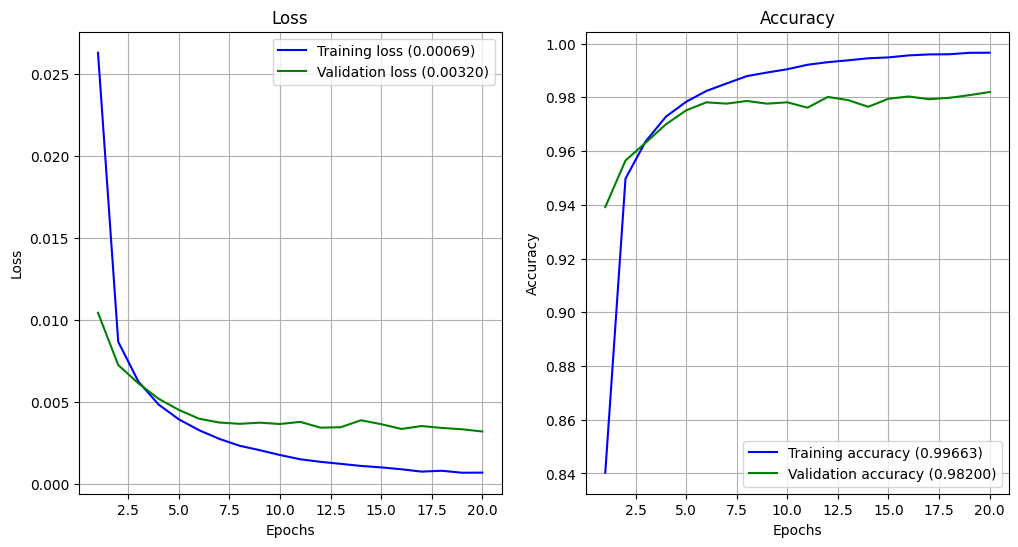

Confusion matrix, without normalization


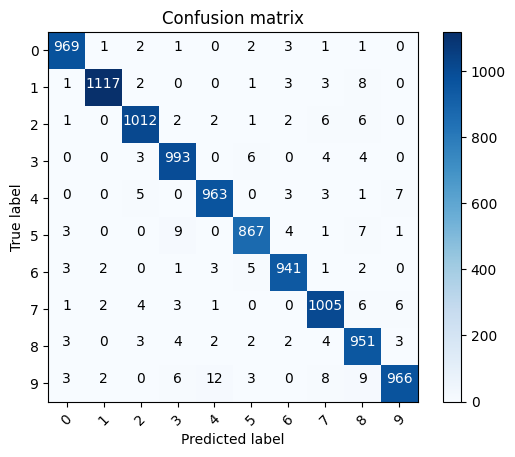

In [11]:
earlystop=EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')
model = Sequential()

# Perceptron de un solo nivel
model.add(Dense(128, activation='relu', input_shape=(num_pixels,)))
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='sigmoid'))


model.compile(loss='mean_squared_error', optimizer=Adam(),  metrics=['accuracy'])
model.summary()

t0 = time.perf_counter()
history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=20,
                    validation_split=0.1,
                    callbacks=[earlystop],
                    verbose=verbose)
train_time = time.perf_counter() - t0
print('%s %.3f%s' %  ('Training time: ', train_time, 's') )
train_score = model.evaluate(x_train, y_train, verbose=0)
test_score = model.evaluate(x_test, y_test, verbose=0)
print(f'Accuracy train: {100 * train_score[1]:.2f}%')
print(f'Accuracy test: {100 * test_score[1]:.2f}%')
y_pred = model.predict(x_test)

plot_history(history)

plot_mnist_confusion_matrix(y_test, y_pred, normalize=False)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Total de imágenes mal clasificadas: 216


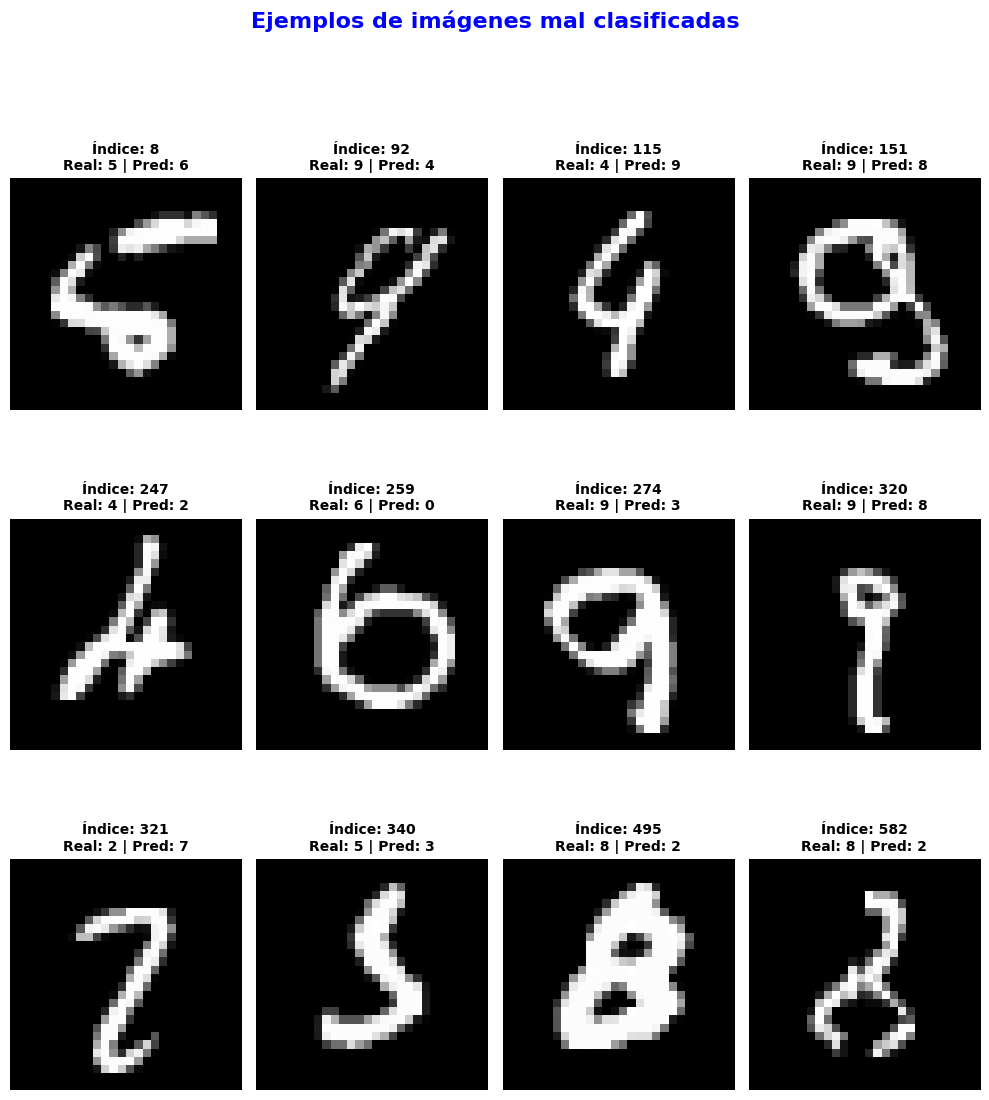

In [12]:
# Obtenemos las predicciones del modelo
predicciones = model.predict(x_test)

# Encontramos las imágenes mal clasificadas
mal_clasificadas = [
    (indice, np.argmax(y_test[indice]), np.argmax(predicciones[indice]))
    for indice in range(len(x_test))
    if np.argmax(predicciones[indice]) != np.argmax(y_test[indice])
]

print(f"Total de imágenes mal clasificadas: {len(mal_clasificadas)}")

if len(mal_clasificadas) > 12:
    mal_clasificadas = mal_clasificadas[:12]  # Si hay más de 12, tomamos solo las primeras 12

# Calculamos dinámicamente las filas necesarias (máximo 3 columnas por fila)
filas = (len(mal_clasificadas) - 1) // 4 + 1

plt.figure(figsize=(10, 4 * filas))  # Ajustamos el tamaño total del gráfico

for i, (indice, clase_real, clase_predicha) in enumerate(mal_clasificadas):
    plt.subplot(filas, 4, i + 1)
    plt.imshow(x_test[indice].reshape(28, 28), cmap='gray')

    # título de la imagen
    plt.title(f"Índice: {indice}\nReal: {clase_real} | Pred: {clase_predicha}",
              fontsize=10, color='black', fontweight='bold')

    plt.axis('off')

# título del gráfico
plt.suptitle("Ejemplos de imágenes mal clasificadas", fontsize=16, color='blue', fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Ajusta el espacio entre elementos y respeta el título principal
plt.show()
